# Trying to beat 0.896

# This also appears to have been run not in the correct order

## Changes:

predicted heatmap is grayscale

In [1]:
%matplotlib inline
import PIL
from PIL import ImageDraw, ImageFont
from os import listdir
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
import math
from tqdm import tqdm_notebook as tqdm
import f1
from importlib import reload
import stable.center_model
import stable.classifier
import stable.predict
import stable.utils

In [2]:
DATA = Path("data")

train_fnames = (DATA/"train_fnames.txt").read_text().split("\n")
valid_fnames = (DATA/"valid_fnames.txt").read_text().split("\n")

df_train = pd.read_csv("data/train.csv")
unicode_map = {codepoint: char for codepoint, char in pd.read_csv('data/unicode_translation.csv').values}

sample_submission = pd.read_csv("data/sample_submission.csv")

## Create heatmaps for all train images and make random crops

In [3]:
make_heatmaps = False

In [4]:
if make_heatmaps:
    stable.center_model.generate_heatmap_crops_circular(
        im_path=DATA/"train_images",
        hm_save_path=DATA/"train_images_heatmaps",
        im_crop_save_path=DATA/"train_images_circular_1024->256",
        hm_crop_save_path=DATA/"train_images_heatmaps_circular_1024->256",
        df=df_train,
        overlap=512,
        crop_size=1024,
        resize_to=256,
        radius=25)

### Make some random crops only

In [5]:
# # Try 1024x1024 crops, resized to 256x256 - the greater context might help with things like detecting images and borders
# if make_heatmaps:
#     generate_crops_circular(im_path=DATA/"train_images",
#                             hm_path=DATA/"train_images_heatmaps",
#                             im_save_path = DATA/"train_images_random_crops_circular_1024->256",
#                             hm_save_path = DATA/"train_images_heatmaps_random_crops_circular_1024->256",
#                             df=df_train,
#                             n_crops=10,
#                             crop_size=1024,
#                             resize_to=256)

## U-Net 1024x1024

In [6]:
seed = 420

# python RNG
import random
random.seed(seed)

# pytorch RNGs
import torch
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
if torch.cuda.is_available(): torch.cuda.manual_seed_all(seed)

# numpy RNG
import numpy as np
np.random.seed(seed)

In [7]:
from fastai.vision import *
from fastai import layers

In [8]:
data = None; gc.collect()

146

In [9]:
size = 256
bs = 16
tfms = get_transforms(do_flip=False, p_lighting=0.0, max_zoom=1.5)

data = (ImageImageList.from_folder(DATA/"train_images_circular_1024->256")
       .split_by_valid_func(lambda x: x.name[:-14] in valid_fnames)
       #.split_none()
       .label_from_func(lambda x: DATA/"train_images_heatmaps_circular_1024->256"/(x.name), convert_mode="L")
       .transform(tfms, tfm_y=True, size=size, resize_method=ResizeMethod.SQUISH)
       .databunch(bs=bs, num_workers=6)
       .normalize(imagenet_stats))

data.c = 1

In [10]:
learn = None; gc.collect()

90

In [19]:
learn = unet_learner(data, models.resnet18, callback_fns=[ShowGraph,
                                                          partial(callbacks.MixedPrecision, loss_scale=1024),
                                                          callbacks.CSVLogger,
                                                          #callbacks.ReduceLROnPlateauCallback
                                                         ],
                    metrics=[mean_squared_error, mean_absolute_error])
learn.loss_func = mean_squared_error

In [9]:
learn.fit(10, 1e-4)

In [10]:
learn.save("20190927_circular_1024->256_10-epochs")

In [11]:
learn.fit(10, 1e-4)

In [12]:
learn.save("20190927_circular_1024->256_20-epochs")

In [13]:
learn.load("20190927_circular_1024->256_20-epochs")

Learner(data=ImageDataBunch;

Train: LabelList (50003 items)
x: ImageImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: ImageList
Image (1, 256, 256),Image (1, 256, 256),Image (1, 256, 256),Image (1, 256, 256),Image (1, 256, 256)
Path: data/train_images_circular_1024->256;

Valid: LabelList (0 items)
x: ImageImageList

y: ImageList

Path: data/train_images_circular_1024->256;

Test: None, model=DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, mom

In [14]:
learn.export("20190927_circular_1024->256_20-epochs")

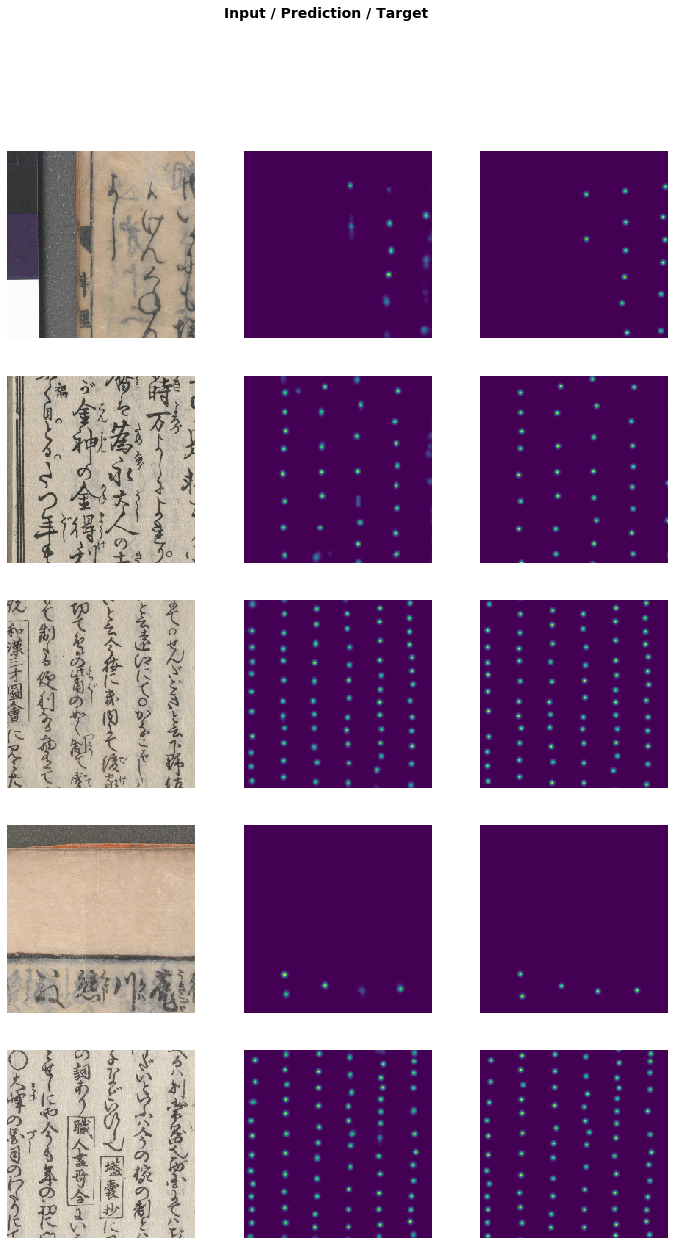

In [20]:
#learn.show_results()

In [36]:
learn.save("20190927_circular_1024->256_24-epochs")

## Inference

In [ ]:
import skimage.feature

In [ ]:
# TODO: detect points in images, no need to re-tile
def get_centers(im, model, hm_threshold=10, hm_min_distance=25):
    im = np.asarray(im)
    block_size = 1024 # was 512 # net takes 256x256 resize of 512x512 block
    model_input_size = 256
    channels = 3
    im_height, im_width = im.shape[:2]
    hm_height, hm_width = im_height // 2, im_width // 2
    blocks = stable.utils.get_image_blocks(im, block_size)
    heatmap = np.zeros([hm_height, hm_width, im.shape[2]], dtype=np.uint8)
    
    for i in range(blocks.shape[0]):
        for j in range(blocks.shape[1]):
            hm_tile = stable.predict.process_output(model.predict(stable.predict.preprocess_input(blocks[i,j])))
            if (i+1) * 256 > hm_height:
                hm_tile = hm_tile[:hm_height%256,:]
            if (j+1) * 256 > hm_width:
                hm_tile = hm_tile[:,:hm_width%256]
            try:
                heatmap[256*i:256*(i+1),256*j:256*(j+1)] = hm_tile
            except Exception as e:
                print(i, j)
                print(heatmap.shape)
                print(hm_tile.shape)
                print(hm_tile)
                raise(e)
            
    # cheers https://stackoverflow.com/questions/51672327/skimage-peak-local-max-finds-multiple-spots-in-close-proximity-due-to-image-impu
    heatmap_gray = np.array(PIL.Image.fromarray(heatmap).convert("L"))
    is_peak = skimage.feature.peak_local_max(heatmap_gray, min_distance=hm_min_distance, indices=False, threshold_abs=hm_threshold)
    labels = scipy.ndimage.measurements.label(is_peak)[0]
    merged_peaks = scipy.ndimage.measurements.center_of_mass(is_peak, labels, range(1, np.max(labels)+1))
    merged_peaks = np.array(merged_peaks) * (block_size / model_input_size)  # scale up to same dimensions as original image
    if len(merged_peaks) > 0:
        merged_peaks[:,[0,1]] = merged_peaks[:,[1,0]]  # for some reason merged_peaks was (y, x) coords
    return merged_peaks

In [ ]:
import stable.utils; import stable.predict

In [ ]:
fn = valid_fnames[100] # 256
print(fn)
im = PIL.Image.open(DATA/"train_images"/f"{fn}.jpg")

fig, ax = plt.subplots(figsize=(20,20))

ax.imshow(im, cmap="gray")
centers = get_centers(im, learn, hm_threshold=20, hm_min_distance=10)
ax.plot(centers[:,0], centers[:,1], "ro")

In [ ]:
classifier = load_learner(path=DATA/"train_images_chars_256", file="20190906_classifier-50-epochs").to_fp32()

### Evaluate on validation set

In [ ]:
valid_truth = pd.DataFrame(df_train[df_train.image_id.isin([name for name in valid_fnames])].values,
                           columns=["image_id", "labels"])
# Sorry for not knowing how to pandas

valid_preds = valid_truth.copy()
for i in range(len(valid_preds)):
    valid_preds.iloc[i].labels = np.nan

In [ ]:
for i in tqdm(range(len(valid_preds))):
    fname = valid_preds.iloc[i].image_id
    im = PIL.Image.open(DATA/"train_images"/f"{fname}.jpg")
    im_arr = np.array(im)
    
    im_height, im_width, colour_depth = im_arr.shape
    # for now just a square area around center
    r=128  # 256x256
    
    predictions = []
    
    centers = get_centers(im, learn, hm_threshold=20, hm_min_distance=10)

    for center_x, center_y in centers:
        center_x = int(center_x)
        center_y = int(center_y)
        x0, y0 = max(0, center_x - r), max(0, center_y - r)
        x1, y1 = center_x + r, center_y + r
        character_region = im_arr[y0:y1, x0:x1]
        prediction = classifier.predict(stable.predict.preprocess_input(character_region))[0].obj
        if prediction != "BACKGROUND":
            predictions.append([prediction, center_x, center_y])
        
        
    if len(predictions) > 0:
        predictions_str = " ".join([" ".join(map(str, i)) for i in predictions])
        valid_preds.iloc[i].labels = predictions_str
    else:
        valid_preds.iloc[i].labels = np.nan
        
    #print(f1.kuzushiji_f1(valid_preds[:i+1], valid_truth[:i+1]))

In [ ]:
f1.kuzushiji_f1(valid_preds, valid_truth, detection_only=False)

In [ ]:
def visualize_training_data(image_fn, preds, labels):
    from PIL import Image, ImageDraw, ImageFont
    fontsize=36
    font = ImageFont.truetype('./NotoSansCJKjp-Regular.otf', fontsize, encoding='utf-8')

    
    # Read image
    imsource = Image.open(image_fn).convert('RGBA')
    bbox_canvas = Image.new('RGBA', imsource.size)
    char_canvas = Image.new('RGBA', imsource.size)
    bbox_draw = ImageDraw.Draw(bbox_canvas) # Separate canvases for boxes and chars so a box doesn't cut off a character
    char_draw = ImageDraw.Draw(char_canvas)

    if type(labels) == str and len(labels) > 0:
        labels = np.array(labels.split(" ")).reshape(-1, 5)
        for codepoint, x, y, w, h in labels:
            x, y, w, h = int(x), int(y), int(w), int(h)
            char = unicode_map[codepoint] # Convert codepoint to actual unicode character

            # Draw bounding box around character, and unicode character next to it
            bbox_draw.rectangle((x, y, x+w, y+h), fill=(255, 255, 255, 0), outline=(255, 0, 0, 255))
            char_draw.text((x + w + fontsize/4, y + h/2 - fontsize), char, fill=(255, 0, 0, 255), font=font)
        
    if type(preds) == str and len(preds) > 0:
        preds = np.array(preds.split(" ")).reshape(-1, 3) 
        for codepoint, x, y in preds:
            x, y = int(x), int(y)
            char = unicode_map[codepoint]
            bbox_draw.rectangle((x-5, y-5, x+5, y+5), fill=(0,0,255,255))
            char_draw.text((x+25, y-fontsize*(3/4)), char, fill=(0, 0, 255, 255), font=font)


    imsource = Image.alpha_composite(Image.alpha_composite(imsource, bbox_canvas), char_canvas)
    imsource = imsource.convert("RGB") # Remove alpha for saving in jpg format.
    return np.asarray(imsource)

In [ ]:
i = 355
# 496, 497

viz = visualize_training_data(DATA/"train_images"/(valid_preds.iloc[i].image_id + ".jpg"), valid_preds.iloc[i].labels, valid_truth.iloc[i].labels)
plt.figure(figsize=(15, 25))
#plt.title(img)
plt.imshow(viz, interpolation='bilinear')
plt.show()

In [ ]:
set(valid_truth.image_id.values) == set(valid_preds.image_id.values)

### Test set predictions

In [ ]:
classifier = None
gc.collect()
classifier = load_learner(path=DATA/"train_images_chars_256", file="20190925_TEST").to_fp32()

In [ ]:
submission = pd.read_csv(DATA/"sample_submission.csv")
for i in range(len(submission)):
    submission.iloc[i].labels = np.nan

In [ ]:
for i in tqdm(range(len(submission))):
    fname = submission.iloc[i].image_id
    im = PIL.Image.open(DATA/"test_images"/f"{fname}.jpg")
    im_arr = np.array(im)
    
    im_height, im_width, colour_depth = im_arr.shape
    # for now just a square area around center
    r=128  # 256x256
    
    predictions = []
    
    centers = get_centers(im, learn, hm_threshold=20, hm_min_distance=10)
    
    for center_x, center_y in centers:
        center_x = int(center_x)
        center_y = int(center_y)
        x0, y0 = max(0, center_x - r), max(0, center_y - r)
        x1, y1 = center_x + r, center_y + r
        character_region = im_arr[y0:y1, x0:x1]
        prediction = classifier.predict(stable.predict.preprocess_input(character_region))[0].obj
        if prediction != "BACKGROUND":
            predictions.append([prediction, center_x, center_y])
        
    if len(predictions) > 0:
        predictions_str = " ".join([" ".join(map(str, i)) for i in predictions])
        submission.iloc[i].labels = predictions_str
    else:
        submission.iloc[i].labels = np.nan

In [ ]:
submission_no = 16

In [ ]:
submission.to_csv(f"submissions/submission{submission_no}.csv", index=False)

In [ ]:
# Also save validation set predictions for same model
valid_preds.to_csv(f"submissions/submission{submission_no}.valid.csv", index=False)

In [ ]:
submission.head()